In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [ ]:
credit = pd.read_csv('credit.csv')

In [ ]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

In [ ]:
data = credit.drop('class', axis=1)
# encode label into 0 and 1
label = credit['class'].map({'good': 0, 'bad': 1})

In [ ]:
# log transform credit_amount
data['credit_amount'] = np.log(data['credit_amount'])

In [ ]:
for col in data.columns:
  if data[col].dtype == 'object':
    print(data[col].value_counts())

checking_status
no checking    394
<0             274
0<=X<200       269
>=200           63
Name: count, dtype: int64
credit_history
existing paid                     530
critical/other existing credit    293
delayed previously                 88
all paid                           49
no credits/all paid                40
Name: count, dtype: int64
purpose
radio/tv               280
new car                234
furniture/equipment    181
used car               103
business                97
education               50
repairs                 22
domestic appliance      12
other                   12
retraining               9
Name: count, dtype: int64
savings_status
<100                603
no known savings    183
100<=X<500          103
500<=X<1000          63
>=1000               48
Name: count, dtype: int64
employment
1<=X<4        339
>=7           253
4<=X<7        174
<1            172
unemployed     62
Name: count, dtype: int64
personal_status
male single           548
female div/dep/ma

In [ ]:
# change "retraining" to "education" and "domestic appliance" to "furniture/equipment"
# data['purpose'] = data['purpose'].replace('retraining', 'education')
# data['purpose'] = data['purpose'].replace('domestic appliance', 'furniture/equipment')

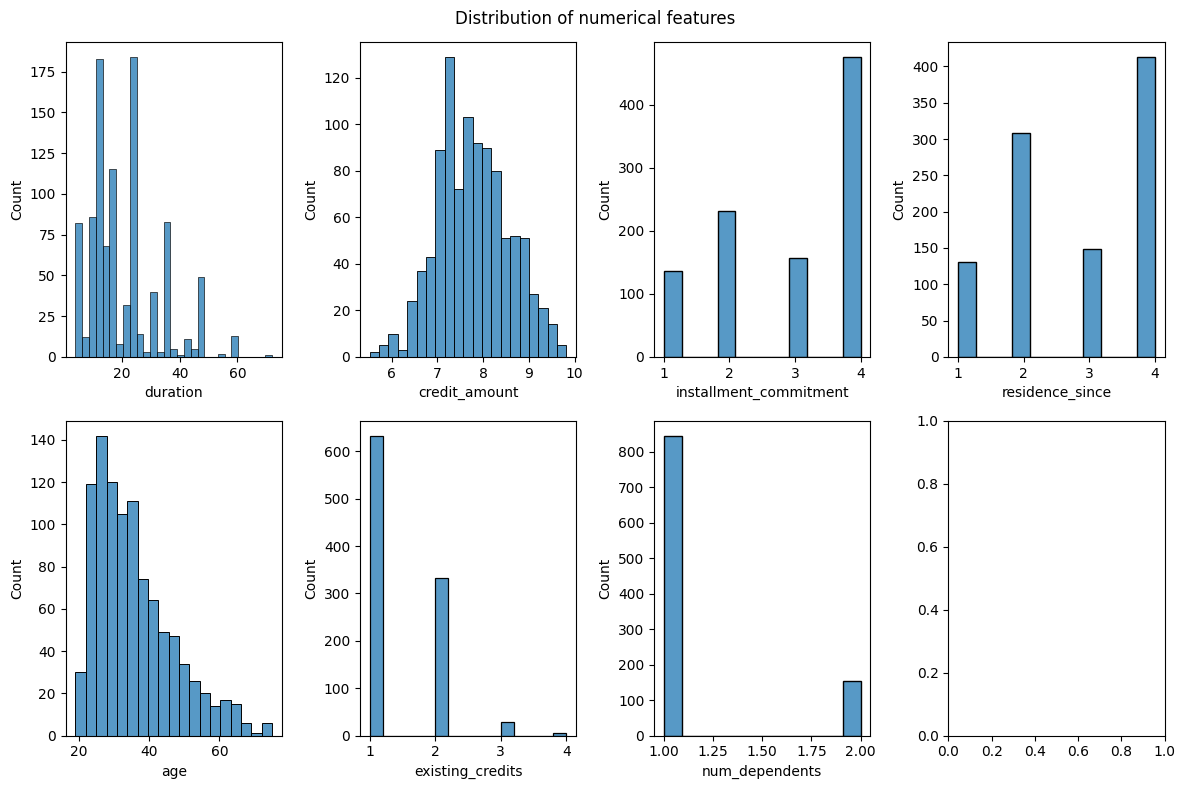

In [ ]:
numeric_col = data.columns[data.dtypes != 'object']
fig, axes = plt.subplots(2,4, figsize=(12, 8))
for i, col in enumerate(numeric_col):
  if data[col].dtype != 'object':
    sns.histplot(data=data, x=col, ax=axes[i//4, i%4])
fig.suptitle("Distribution of numerical features")
plt.tight_layout()

In [ ]:
categorical_col = list(set(data.columns) - set(numeric_col))

In [ ]:
data_ordered = pd.concat([data[numeric_col], data[categorical_col]], axis=1)

In [ ]:
# one hot encode categorical data
data_encoded = pd.get_dummies(data_ordered, columns=categorical_col).astype(int)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_encoded[numeric_col]= scaler.fit_transform(data_encoded[numeric_col])

In [ ]:
# build logistic model to evaluate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

CUTOFF = round((1/5)*(0.3/0.7),3)
COSTMATRIX = np.array([[0, 1], [5, 0]])
def evaluate_logistic_model(X, y):

  results = []
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    lg = LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced')
    lg.fit(X_train, y_train)
    y_pred_prob = lg.predict_proba(X_test)[:, 1]
    for cutoff in [0.5, 0.4, 0.3, 0.2, CUTOFF]:
      y_pred = np.where(y_pred_prob > cutoff, 1, 0)
      cm = confusion_matrix(y_test, y_pred)
      precision = precision_score(y_test, y_pred, zero_division=0)
      recall = recall_score(y_test, y_pred, zero_division=0)
      f1 = f1_score(y_test, y_pred, zero_division=0)
      roc_auc = roc_auc_score(y_test, y_pred_prob)
      cost = np.sum(cm * COSTMATRIX)
      results.append({
        'cutoff': cutoff,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cost': cost,
        'roc_auc': roc_auc
      })
  results_df = pd.DataFrame(results)
  return results_df

In [ ]:
results_df=evaluate_logistic_model(data_encoded.to_numpy(), label.to_numpy())
results_df.groupby('cutoff').mean()

,precision,recall,f1_score,cost,roc_auc
cutoff,,,,,
0.086,0.327220,0.990000,0.491827,125.2,0.780762
0.200,0.383411,0.940000,0.544455,108.8,0.780762
0.300,0.420175,0.870000,0.566465,111.0,0.780762
0.400,0.474396,0.803333,0.596230,112.4,0.780762
0.500,0.524001,0.720000,0.606291,123.4,0.780762


In [ ]:
# use PCA encoding to train logistic model
from sklearn.decomposition import PCA
def evaluate_pca_logistic_model(X, y):

  results = []
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pca = PCA(n_components=30)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    lg = LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced')
    lg.fit(X_train, y_train)
    y_pred_prob = lg.predict_proba(X_test)[:, 1]
    for cutoff in [0.5, 0.4, 0.3, 0.2, CUTOFF]:
      y_pred = np.where(y_pred_prob > cutoff, 1, 0)
      cm = confusion_matrix(y_test, y_pred)
      precision = precision_score(y_test, y_pred, zero_division=0)
      recall = recall_score(y_test, y_pred, zero_division=0)
      f1 = f1_score(y_test, y_pred, zero_division=0)
      roc_auc = roc_auc_score(y_test, y_pred_prob)
      cost = np.sum(cm * COSTMATRIX)
      results.append({
        'cutoff': cutoff,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cost': cost,
        'roc_auc': roc_auc
      })
  results_df = pd.DataFrame(results)
  return results_df

In [ ]:
pca_results_df = evaluate_pca_logistic_model(data_encoded.to_numpy(), label.to_numpy())
pca_results_df.groupby('cutoff').mean()

,precision,recall,f1_score,cost,roc_auc
cutoff,,,,,
0.086,0.319927,0.996667,0.484339,128.2,0.761714
0.200,0.366080,0.940000,0.526758,115.8,0.761714
0.300,0.408903,0.876667,0.557398,113.0,0.761714
0.400,0.454879,0.810000,0.582163,115.2,0.761714
0.500,0.485811,0.693333,0.571033,136.2,0.761714


In [ ]:
cutoffs = [CUTOFF, 0.2, 0.3, 0.4, 0.5]
COSTMATRIX = np.array([[0, 1], [5, 0]])

def evaluate_autoencoder_lg(X, y, encoder, decoder, cutoffs, epochs):
  results = []
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    encoder_model = encoder()
    decoder_model = decoder()
    autoencoder = tf.keras.Sequential([encoder_model, decoder_model])
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=500,
        decay_rate=0.95)
    autoencoder.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule), loss='mse')
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = autoencoder.fit(X_train, X_train, epochs=epochs,
                              batch_size=32, callbacks=[early_stopping],
                              shuffle=True, validation_split=0.2)
    X_train_encoded = encoder_model.predict(X_train)
    X_test_encoded = encoder_model.predict(X_test)
    X_test_loss = autoencoder.evaluate(X_test, X_test)

    for cutoff in cutoffs:
      lg = LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced')
      lg.fit(X_train_encoded, y_train)
      y_pred_prob = lg.predict_proba(X_test_encoded)[:, 1]
      y_pred = np.where(y_pred_prob > cutoff, 1, 0)

      cm = confusion_matrix(y_test, y_pred)
      precision = precision_score(y_test, y_pred, zero_division=0)
      recall = recall_score(y_test, y_pred, zero_division=0)
      f1 = f1_score(y_test, y_pred, zero_division=0)
      roc_auc = roc_auc_score(y_test, y_pred_prob)
      cost = np.sum(cm * COSTMATRIX)

      results.append({
        'cutoff': cutoff,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cost': cost,
        'roc_auc': roc_auc,
        'test_loss': X_test_loss
      })

  return results

In [ ]:
input_dim = data_encoded.shape[1]
leaky_relu = tf.keras.layers.LeakyReLU(negative_slope=0.1)

In [ ]:
def basic_encoder():
    encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=[input_dim]),
      tf.keras.layers.Dense(30),
    ])
    return encoder

def basic_decoder():
    decoder = tf.keras.layers.Dense(input_dim)
    return decoder

In [ ]:
basic_lg_results = evaluate_autoencoder_lg(data_encoded.to_numpy(), label.to_numpy(), basic_encoder, basic_decoder, cutoffs, epochs=100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2525 - val_loss: 0.0826
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0697 - val_loss: 0.0471
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0418 - val_loss: 0.0326
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0288 - val_loss: 0.0250
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 - val_loss: 0.0211
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0185 - val_loss: 0.0186
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - val_loss: 0.0166
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0150 - val_loss: 0.0155
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0142 - val_loss: 0.0147
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0129 - val_loss: 0.0141
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - val_loss: 0.0137
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

In [ ]:
pd.DataFrame(basic_lg_results).groupby('cutoff').mean()

,precision,recall,f1_score,cost,roc_auc,test_loss
cutoff,,,,,,
0.086,0.319586,1.000000,0.484346,127.8,0.766929,0.011846
0.200,0.371604,0.956667,0.535175,110.2,0.766929,0.011846
0.300,0.408312,0.893333,0.560187,109.6,0.766929,0.011846
0.400,0.458079,0.810000,0.584895,114.4,0.766929,0.011846
0.500,0.482230,0.700000,0.570960,135.2,0.766929,0.011846


In [ ]:
def basic_nlact_encoder():
    encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=[input_dim]),
      tf.keras.layers.Dense(30, activation=leaky_relu, kernel_initializer='he_normal',bias_initializer='zeros'),
    ])
    return encoder
basic_nlact_lg_results = evaluate_autoencoder_lg(data_encoded.to_numpy(), label.to_numpy(), basic_nlact_encoder, basic_decoder, cutoffs, epochs=100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2417 - val_loss: 0.1069
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0951 - val_loss: 0.0736
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0643 - val_loss: 0.0532
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0466 - val_loss: 0.0401
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0349 - val_loss: 0.0325
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0278 - val_loss: 0.0268
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0234 - val_loss: 0.0233
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0213 - val_loss: 0.0212
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0182 - val_loss: 0.0198
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0174 - val_loss: 0.0187
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0157 - val_loss: 0.0179
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss:

In [ ]:
pd.DataFrame(basic_nlact_lg_results).groupby('cutoff').mean()

,precision,recall,f1_score,cost,roc_auc,test_loss
cutoff,,,,,,
0.086,0.316112,0.993333,0.479574,131.0,0.765643,0.014261
0.200,0.366291,0.966667,0.531172,110.4,0.765643,0.014261
0.300,0.404956,0.890000,0.556474,111.4,0.765643,0.014261
0.400,0.457348,0.820000,0.586988,112.4,0.765643,0.014261
0.500,0.486194,0.730000,0.583510,127.4,0.765643,0.014261


In [ ]:
def stacked_encoder():
    encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=[input_dim]),
      tf.keras.layers.Dense(40),
      tf.keras.layers.Dense(20),
    ])
    return encoder
def stacked_decoder():
    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(40),
        tf.keras.layers.Dense(input_dim),
      ])
    return decoder

stacked_lg_results = evaluate_autoencoder_lg(data_encoded.to_numpy(), label.to_numpy(), stacked_encoder, stacked_decoder, cutoffs, epochs=100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2258 - val_loss: 0.0809
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0724 - val_loss: 0.0533
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0484 - val_loss: 0.0409
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0383 - val_loss: 0.0363
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0334 - val_loss: 0.0342
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0322 - val_loss: 0.0327
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0299 - val_loss: 0.0323
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0300 - val_loss: 0.0318
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0300 - val_loss: 0.0311
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0292 - val_loss: 0.0304
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0291 - val_loss: 0.0303
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

In [ ]:
pd.DataFrame(stacked_lg_results).groupby('cutoff').mean()

,precision,recall,f1_score,cost,roc_auc,test_loss
cutoff,,,,,,
0.086,0.313374,1.000000,0.477142,131.6,0.76419,0.028702
0.200,0.364183,0.966667,0.528924,111.4,0.76419,0.028702
0.300,0.403299,0.883333,0.553386,113.4,0.76419,0.028702
0.400,0.447256,0.816667,0.577519,115.6,0.76419,0.028702
0.500,0.483556,0.710000,0.575043,132.6,0.76419,0.028702


In [ ]:
def sparse_encoder():
  encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[input_dim]),
    tf.keras.layers.Dense(60),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
  ])
  return encoder
def sparse_decoder():
    decoder = tf.keras.layers.Dense(input_dim)
    return decoder

sparse_lg_results = evaluate_autoencoder_lg(data_encoded.to_numpy(), label.to_numpy(), sparse_encoder, sparse_decoder, cutoffs, 100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2734 - val_loss: 0.0980
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0845 - val_loss: 0.0622
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0585 - val_loss: 0.0493
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0457 - val_loss: 0.0415
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0397 - val_loss: 0.0382
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0361 - val_loss: 0.0332
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0315 - val_loss: 0.0306
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0307 - val_loss: 0.0330
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0291 - val_loss: 0.0275
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0259 - val_loss: 0.0276
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0274 - val_loss: 0.0247
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [ ]:
pd.DataFrame(sparse_lg_results).groupby('cutoff').mean()

,precision,recall,f1_score,cost,roc_auc,test_loss
cutoff,,,,,,
0.086,0.302157,1.000000,0.464075,138.6,0.78,0.013547
0.200,0.335537,0.990000,0.501074,120.8,0.78,0.013547
0.300,0.388234,0.930000,0.547533,109.0,0.78,0.013547
0.400,0.441210,0.843333,0.578902,111.2,0.78,0.013547
0.500,0.503245,0.720000,0.591892,127.0,0.78,0.013547


In [ ]:
def dropout_encoder():
  encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[input_dim]),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(40),
  ])
  return encoder
def dropout_decoder():
    decoder = tf.keras.layers.Dense(input_dim)
    return decoder

dropout_lg_results = evaluate_autoencoder_lg(data_encoded.to_numpy(), label.to_numpy(), dropout_encoder, dropout_decoder, cutoffs, 100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3276 - val_loss: 0.0819
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0907 - val_loss: 0.0501
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0660 - val_loss: 0.0382
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0570 - val_loss: 0.0328
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0530 - val_loss: 0.0283
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0496 - val_loss: 0.0270
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0486 - val_loss: 0.0253
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0452 - val_loss: 0.0241
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0462 - val_loss: 0.0236
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0427 - val_loss: 0.0223
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0444 - val_loss: 0.0225
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [ ]:
pd.DataFrame(dropout_lg_results).groupby('cutoff').mean()

,precision,recall,f1_score,cost,roc_auc,test_loss
cutoff,,,,,,
0.086,0.319135,0.990000,0.482638,129.8,0.770976,0.018465
0.200,0.374473,0.950000,0.537085,110.4,0.770976,0.018465
0.300,0.406656,0.856667,0.551230,118.0,0.770976,0.018465
0.400,0.457288,0.783333,0.577155,120.6,0.770976,0.018465
0.500,0.507724,0.696667,0.587180,131.6,0.770976,0.018465


In [ ]:
def mixed_encoder():
  encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[input_dim]),
    tf.keras.layers.Dense(120, activation=leaky_relu, kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(60, activation=leaky_relu, kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(30, activation=leaky_relu, kernel_initializer='he_normal'),
  ])
  return encoder
def mixed_decoder():
    decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(120, activation=leaky_relu, kernel_initializer='he_normal'),
    tf.keras.layers.Dense(input_dim),
  ])
    return decoder

mixed_lg_results = evaluate_autoencoder_lg(data_encoded.to_numpy(), label.to_numpy(), mixed_encoder, mixed_decoder, cutoffs, 100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.8300 - val_loss: 0.1707
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1474 - val_loss: 0.1432
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1155 - val_loss: 0.1215
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1020 - val_loss: 0.1036
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0911 - val_loss: 0.0948
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0833 - val_loss: 0.0900
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0808 - val_loss: 0.0822
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0748 - val_loss: 0.0766
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0697 - val_loss: 0.0728
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0685 - val_loss: 0.0696
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0649 - val_loss: 0.0667
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [ ]:
pd.DataFrame(mixed_lg_results).groupby('cutoff').mean()

,precision,recall,f1_score,cost,roc_auc,test_loss
cutoff,,,,,,
0.086,0.316914,0.996667,0.480858,130.0,0.757667,0.015667
0.200,0.361407,0.943333,0.522392,117.2,0.757667,0.015667
0.300,0.402885,0.873333,0.551141,115.6,0.757667,0.015667
0.400,0.442220,0.790000,0.566804,122.8,0.757667,0.015667
0.500,0.484554,0.673333,0.563424,141.0,0.757667,0.015667


Test multiple-output architecture: use MSE for numerical features and BinaryCrossEntropy for categorical features

In [ ]:
cutoffs = [CUTOFF, 0.2, 0.3, 0.4, 0.5]
COSTMATRIX = np.array([[0, 1], [5, 0]])

def prediction_metric(X_train_encoded, X_test_encoded, y_train, y_test, cutoffs):
  results = []
  for cutoff in cutoffs:
    lg = LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced')
    lg.fit(X_train_encoded, y_train)
    y_pred_prob = lg.predict_proba(X_test_encoded)[:, 1]
    y_pred = np.where(y_pred_prob > cutoff, 1, 0)

    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    cost = np.sum(cm * COSTMATRIX)

    results.append({
        'cutoff': cutoff,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cost': cost,
        'roc_auc': roc_auc
    })
  return results

In [ ]:
def evaluate_basic_lg(X, y, cutoffs, epochs):
  test_loss = []
  classification_results = []
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    input_layer = tf.keras.layers.Input(shape=(input_dim,))
    encoder = tf.keras.layers.Dense(30, activation='relu')(input_layer)

    # Decoder outputs
    num_output = tf.keras.layers.Dense(7, activation='linear', name='num_output')(encoder)
    cat_output = tf.keras.layers.Dense(54, activation='sigmoid', name='cat_output')(encoder)

    autoencoder = tf.keras.Model(input_layer, [num_output, cat_output])

    losses = {
        'num_output': 'mse',
        'cat_output': 'binary_crossentropy'
    }

    loss_weights = {'num_output': 0.2, 'cat_output': 0.8}

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=500,
        decay_rate=0.95)
    autoencoder.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule), loss=losses,loss_weights=loss_weights)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    X_train_num = X_train[:, :7]
    X_train_cat = X_train[:, 7:]

    history = autoencoder.fit(X_train, [X_train_num, X_train_cat], epochs=epochs,
                              batch_size=32, callbacks=[early_stopping],
                              shuffle=True, validation_split=0.2)

    encoder_model = tf.keras.Model(input_layer, encoder)
    X_train_encoded = encoder_model.predict(X_train)
    X_test_encoded = encoder_model.predict(X_test)

    X_test_num = X_test[:, :7]
    X_test_cat = X_test[:, 7:]
    eval_results = autoencoder.evaluate(X_test, [X_test_num, X_test_cat], verbose=0)
    test_loss.append(eval_results[0])
    results = prediction_metric(tf.keras.Model(input_layer, encoder).predict(X_train), X_test_encoded, y_train, y_test, cutoffs)


  return results, np.mean(test_loss)

In [ ]:
basic_lg_results = evaluate_basic_lg(data_encoded.to_numpy(), label.to_numpy(), cutoffs, epochs=100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - cat_output_loss: 0.5889 - loss: 0.5071 - num_output_loss: 0.1801 - val_cat_output_loss: 0.3721 - val_loss: 0.3148 - val_num_output_loss: 0.0854
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cat_output_loss: 0.3528 - loss: 0.2959 - num_output_loss: 0.0683 - val_cat_output_loss: 0.3098 - val_loss: 0.2564 - val_num_output_loss: 0.0426
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cat_output_loss: 0.2927 - loss: 0.2406 - num_output_loss: 0.0322 - val_cat_output_loss: 0.2414 - val_loss: 0.1985 - val_num_output_loss: 0.0270
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cat_output_loss: 0.2162 - loss: 0.1776 - num_output_loss: 0.0233 - val_cat_output_loss: 0.1835 - val_loss: 0.1509 - val_num_output_loss: 0.0208
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cat_output_loss: 0.1669 - loss: 0.1380 - num_output_loss: 0.0227 - val_cat_output_loss: 0.1425 - val_loss: 0.1205 - val_num_output_loss: 0.0326
Epoch 6/100
20

In [ ]:
pd.DataFrame(basic_lg_results[0]).groupby('cutoff').mean()

,precision,recall,f1_score,cost,roc_auc
cutoff,,,,,
0.086,0.317460,1.000000,0.481928,129.0,0.765595
0.200,0.361842,0.916667,0.518868,122.0,0.765595
0.300,0.407692,0.883333,0.557895,112.0,0.765595
0.400,0.485149,0.816667,0.608696,107.0,0.765595
0.500,0.530864,0.716667,0.609929,123.0,0.765595


### Selected features

In [ ]:
# perform univariate feature selection
from sklearn.feature_selection import SelectKBest, chi2
data_cat = data.drop(numeric_col, axis=1)
data_cat_encoded = pd.get_dummies(data_cat, columns=categorical_col)
selector_chi2 = SelectKBest(chi2, k='all')
selector_chi2.fit(data_cat_encoded, label)

SelectKBest(k='all', score_func=<function chi2 at 0x7f5b8ad28b80>)

In [ ]:
selector_chi2_results = pd.DataFrame({'feature': data_cat_encoded.columns, 'score': selector_chi2.scores_, 'p-value': selector_chi2.pvalues_})
selector_chi2_results.sort_values(by='p-value', ascending=True)

,feature,score,p-value
32,checking_status_no checking,63.002659,2.064277e-15
30,checking_status_<0,48.450469,3.387373e-12
46,credit_history_critical/other existing credit,23.344872,1.354040e-06
49,credit_history_no credits/all paid,20.119048,7.276835e-06
45,credit_history_all paid,17.190476,3.381273e-05
37,savings_status_no known savings,13.645850,2.207287e-04
40,property_magnitude_no known property,13.377860,2.546120e-04
29,checking_status_0<=X<200,10.453001,1.224504e-03
35,savings_status_<100,10.291479,1.336459e-03
41,property_magnitude_real estate,10.218845,1.390129e-03


In [ ]:
selector_classif = SelectKBest(k='all')
selector_classif.fit(data[numeric_col], label)
selector_classif_results = pd.DataFrame({'feature': numeric_col, 'score': selector_classif.scores_, 'p-value': selector_classif.pvalues_})
selector_classif_results.sort_values(by='p-value', ascending=True)

,feature,score,p-value
0,duration,48.333790,6.488050e-12
1,credit_amount,12.127093,5.184875e-04
4,age,8.356995,3.925339e-03
2,installment_commitment,5.259417,2.203549e-02
5,existing_credits,2.091652,1.484198e-01
6,num_dependents,0.009071,9.241409e-01
3,residence_since,0.008787,9.253374e-01


In [ ]:
data_reduced = data_encoded.drop(selector_chi2_results[selector_chi2_results['p-value'] > 0.1]['feature'], axis=1)
data_reduced = data_reduced.drop(selector_classif_results[selector_classif_results['p-value'] > 0.1]['feature'], axis=1)

In [ ]:
data_reduced.shape

(1000, 31)

In [ ]:
results_df=evaluate_logistic_model(data_reduced.to_numpy(), label.to_numpy())
results_df.groupby('cutoff').mean()

,precision,recall,f1_score,cost,roc_auc
cutoff,,,,,
0.086,0.325152,0.993333,0.489867,125.8,0.791357
0.200,0.376743,0.936667,0.537250,112.0,0.791357
0.300,0.417765,0.883333,0.567113,108.8,0.791357
0.400,0.476292,0.830000,0.604907,105.8,0.791357
0.500,0.527625,0.723333,0.609868,122.0,0.791357


In [ ]:
# generate second degree interaction features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
data_poly = poly.fit_transform(data_reduced)

In [ ]:
# delete columns with all 0 in data_poly
zero_cols = []
for i in range(data_poly.shape[1]):
  if np.all(data_poly[:, i] == 0):
    zero_cols.append(i)
data_poly = np.delete(data_poly, zero_cols, axis=1)

In [ ]:
data_poly.shape

(1000, 461)

In [ ]:
poly_results_df = evaluate_logistic_model(data_poly, label)
poly_results_df.groupby('cutoff').mean()

,precision,recall,f1_score,cost,roc_auc
cutoff,,,,,
0.086,0.369900,0.940000,0.530764,114.2,0.77581
0.200,0.422096,0.860000,0.566141,112.6,0.77581
0.300,0.453379,0.790000,0.575810,120.2,0.77581
0.400,0.484111,0.723333,0.579727,129.4,0.77581
0.500,0.527961,0.656667,0.585039,138.4,0.77581


In [ ]:
pca_results_df = evaluate_pca_logistic_model(data_poly, label.to_numpy())
pca_results_df.groupby('cutoff').mean()

,precision,recall,f1_score,cost,roc_auc
cutoff,,,,,
0.086,0.329893,0.996667,0.495644,122.6,0.788667
0.200,0.377505,0.933333,0.537490,112.4,0.788667
0.300,0.415380,0.876667,0.563536,111.0,0.788667
0.400,0.470677,0.806667,0.594275,112.4,0.788667
0.500,0.523783,0.733333,0.610874,120.0,0.788667


In [ ]:
input_dim = data_poly.shape[1]
leaky_relu = tf.keras.layers.LeakyReLU(negative_slope=0.1)
def stacked_encoder():
    encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=[input_dim]),
      tf.keras.layers.Dense(100),
      tf.keras.layers.Dense(30),
    ])
    return encoder
def stacked_decoder():
    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(100),
        tf.keras.layers.Dense(input_dim),
      ])
    return decoder

stacked_lg_results = evaluate_autoencoder_lg(data_poly, label.to_numpy(), stacked_encoder, stacked_decoder, cutoffs, epochs=100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0698 - val_loss: 0.0293
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0248 - val_loss: 0.0207
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179 - val_loss: 0.0182
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0161 - val_loss: 0.0171
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0152 - val_loss: 0.0166
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0148 - val_loss: 0.0161
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - val_loss: 0.0158
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - val_loss: 0.0158
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0137 - val_loss: 0.0155
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0140 - val_loss: 0.0156
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - val_loss: 0.0157
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [ ]:
pd.DataFrame(stacked_lg_results).groupby('cutoff').mean()

,precision,recall,f1_score,cost,roc_auc,test_loss
cutoff,,,,,,
0.086,0.326185,0.996667,0.491479,124.6,0.788643,0.014962
0.200,0.374310,0.933333,0.534146,113.8,0.788643,0.014962
0.300,0.417895,0.883333,0.567295,108.8,0.788643,0.014962
0.400,0.465284,0.810000,0.590610,113.0,0.788643,0.014962
0.500,0.534689,0.716667,0.612278,122.4,0.788643,0.014962


In [ ]:
def sparse_encoder():
  encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[input_dim]),
    tf.keras.layers.Dense(100, activation=leaky_relu, kernel_initializer='he_normal'), # activation added because gradient explodes without it
    tf.keras.layers.Dense(200, activation=leaky_relu, kernel_initializer='he_normal'),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
  ])
  return encoder
def sparse_decoder():
    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(100, activation=leaky_relu, kernel_initializer='he_normal'),
        tf.keras.layers.Dense(input_dim),
      ])
    return decoder

sparse_lg_results = evaluate_autoencoder_lg(data_poly, label.to_numpy(), sparse_encoder, sparse_decoder, cutoffs, epochs=100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0917 - val_loss: 0.0526
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0502 - val_loss: 0.0490
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0462 - val_loss: 0.0435
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0392 - val_loss: 0.0387
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0364 - val_loss: 0.0355
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0329 - val_loss: 0.0350
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0308 - val_loss: 0.0331
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0309 - val_loss: 0.0314
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0284 - val_loss: 0.0311
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0277 - val_loss: 0.0296
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0254 - val_loss: 0.0281
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss

In [ ]:
pd.DataFrame(sparse_lg_results).groupby('cutoff').mean()

,precision,recall,f1_score,cost,roc_auc,test_loss
cutoff,,,,,,
0.086,0.300000,1.000000,0.461538,140.0,0.769548,0.017623
0.200,0.300000,1.000000,0.461538,140.0,0.769548,0.017623
0.300,0.309197,0.996667,0.471865,134.8,0.769548,0.017623
0.400,0.367140,0.956667,0.529999,112.6,0.769548,0.017623
0.500,0.490782,0.703333,0.577858,133.0,0.769548,0.017623


In [ ]:
def dropout_encoder():
  encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[input_dim]),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(100, activation=leaky_relu, kernel_initializer='he_normal'), # activation added because learning is stabler with it
    tf.keras.layers.Dense(30, activation=leaky_relu, kernel_initializer='he_normal'),
  ])
  return encoder
dropout_lg_results = evaluate_autoencoder_lg(data_poly, label.to_numpy(), dropout_encoder, sparse_decoder, cutoffs, epochs=100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0616 - val_loss: 0.0395
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0374 - val_loss: 0.0329
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0317 - val_loss: 0.0290
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0274 - val_loss: 0.0254
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0244 - val_loss: 0.0234
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0221 - val_loss: 0.0221
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0215 - val_loss: 0.0209
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0199 - val_loss: 0.0201
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0194 - val_loss: 0.0195
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0176 - val_loss: 0.0185
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0175 - val_loss: 0.0180
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [ ]:
pd.DataFrame(dropout_lg_results).groupby('cutoff').mean()

,precision,recall,f1_score,cost,roc_auc,test_loss
cutoff,,,,,,
0.086,0.312598,1.000000,0.476277,132.0,0.782143,0.011705
0.200,0.355410,0.953333,0.517656,118.0,0.782143,0.011705
0.300,0.409238,0.906667,0.563835,106.6,0.782143,0.011705
0.400,0.450796,0.830000,0.584085,111.8,0.782143,0.011705
0.500,0.519383,0.716667,0.601836,124.8,0.782143,0.011705
